$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# 06.1 Gradient Descent with Adam

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

So far we have been using SGD or full-gradient steepest descent to find good weights.  Sometimes other ways of using error gradients will lead to fewer steps to reach good weights.  

Here we implement one of these ways, called Adam, for adaptive moment estimation.  In class, we will review the information provided in the following links:
* [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) by Jason Brownlee 
* [ADAM: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf) by Diederik Kingma and Jimmy Lei Ba

But first, to use general-purpose gradient descent algorithms, we should collect all of the weights in a neural network into one vector.  This way we can use the gradient descent algorithms for any optimization problem for which we can arrange the parameters in a vector.

Say we have assigned weight matrices, $V$ and $W$, for our hidden and output layer weights, as we have before.  To collect all of these weights into a single vector, we can use the following function.

In [3]:
def pack(V, W):
    return np.hstack((V.flat, W.flat))

Let's test this before going any further.

In [4]:
V = np.arange(10).reshape(5, 2).astype(np.float64) # create some numbers to represent hidden later weights
W = 20 + np.arange(18).reshape(3, 6).astype(np.float64) # create some numbers to represent output layer weights
V.shape, W.shape

((5, 2), (3, 6))

In [5]:
print(V)
print(W)

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]
 [8. 9.]]
[[20. 21. 22. 23. 24. 25.]
 [26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37.]]


In [6]:
V.flat[:], W.flat[:]

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
        33., 34., 35., 36., 37.]))

In [7]:
pack(V, W)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37.])

Imagine we have sent this vector of weights off to an optimization function (which uses gradient descent) and it returns new weight values.  Now we need to unpack this vector back into the $V$ and $W$ matrices.  Here is a function to do that.

In [8]:
def unpack(w, Vshape, Wshape, verbose=False):
    Vrows, Vcols = Vshape
    Wrows, Wcols = Wshape
    if verbose:
        print("V has %s rows and %s columns" % (Vrows,Vcols))
        print("W has %s rows and %s columns" % (Wrows,Wcols))
    
    V = w[:Vrows * Vcols].reshape(Vshape)
    W = w[Vrows * Vcols:].reshape(Wshape)
    if verbose:
        print("V = %s reshaped to %s" % (w[:Vrows * Vcols], Vshape))
        print("W = %s reshaped to %s" % (w[Vrows * Vcols:], Wshape))
    return V, W

In [9]:
w = pack(V, W)
w

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37.])

In [10]:
V, W = unpack(w, V.shape, W.shape, True)
V, W

V has 5 rows and 2 columns
W has 3 rows and 6 columns
V = [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] reshaped to (5, 2)
W = [20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.] reshaped to (3, 6)


(array([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.],
        [8., 9.]]),
 array([[20., 21., 22., 23., 24., 25.],
        [26., 27., 28., 29., 30., 31.],
        [32., 33., 34., 35., 36., 37.]]))

How is `V` defined?  That is, what happens when we run a cell that invokes `V`?

In [11]:
w[0]=2000
V

array([[2.e+03, 1.e+00],
       [2.e+00, 3.e+00],
       [4.e+00, 5.e+00],
       [6.e+00, 7.e+00],
       [8.e+00, 9.e+00]])

Wait, what's going on here?  I didn't recalculate `V`.  Why did its value change?

In [12]:
#V, W = unpack(w, V.shape, W.shape, True) #don't run this
V2 = np.array(V) # this creates a new ndarray object
V2, W

(array([[2.e+03, 1.e+00],
        [2.e+00, 3.e+00],
        [4.e+00, 5.e+00],
        [6.e+00, 7.e+00],
        [8.e+00, 9.e+00]]),
 array([[20., 21., 22., 23., 24., 25.],
        [26., 27., 28., 29., 30., 31.],
        [32., 33., 34., 35., 36., 37.]]))

In [13]:
w[0]=1000
V2

array([[2.e+03, 1.e+00],
       [2.e+00, 3.e+00],
       [4.e+00, 5.e+00],
       [6.e+00, 7.e+00],
       [8.e+00, 9.e+00]])

`V2[0,0]` didn't change!  This is because the `unpack` method creates output matrices that preserve the same places in memory as the vector `w` that was used to create them.  If you change `w`, you change `V`.  You can use this for efficient memory, but also be careful!

In [14]:
w

array([1000.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.])

Must update w in place to change the values in V, W.  `w = w * 0.1` does not change in place.

In [15]:
w *= 0.1  # update w in place without creating new version of w.   w = w * 0.1 does create new version

In [16]:
w

array([100. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,
         0.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7])

In [17]:
V, W

(array([[100. ,   0.1],
        [  0.2,   0.3],
        [  0.4,   0.5],
        [  0.6,   0.7],
        [  0.8,   0.9]]),
 array([[2. , 2.1, 2.2, 2.3, 2.4, 2.5],
        [2.6, 2.7, 2.8, 2.9, 3. , 3.1],
        [3.2, 3.3, 3.4, 3.5, 3.6, 3.7]]))

Another way to update values in an array without creating new memory:

In [18]:
w[:] = w * 100
w

array([10000.,    10.,    20.,    30.,    40.,    50.,    60.,    70.,
          80.,    90.,   200.,   210.,   220.,   230.,   240.,   250.,
         260.,   270.,   280.,   290.,   300.,   310.,   320.,   330.,
         340.,   350.,   360.,   370.])

In [19]:
V, W

(array([[10000.,    10.],
        [   20.,    30.],
        [   40.,    50.],
        [   60.,    70.],
        [   80.,    90.]]),
 array([[200., 210., 220., 230., 240., 250.],
        [260., 270., 280., 290., 300., 310.],
        [320., 330., 340., 350., 360., 370.]]))

## Adam

"Adam" is short for "**Ada**ptive **M**oment Estimation."  It is not an acronym, and is spelled "Adam" (not ADAM).

Benefits:
* Straightforward to implement.
* Computationally efficient.
* Little memory requirements.
* Invariant to diagonal rescale of the gradients.
* Well suited for problems that are large in terms of data and/or parameters.
* Appropriate for non-stationary objectives.
* Appropriate for problems with very noisy/or sparse gradients.
* Hyper-parameters have intuitive interpretation and typically require little tuning.

SGD maintains a single learning rate ($\rho$) for all weight updates and the learning rate does not change during training.

Adam combines the benefits of two extensions to SGD:
* **Adaptive Gradient Algorithm** (*AdaGrad*) - maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g., natural language and computer vision problems)
* **Root Mean Square Propagation** (*RMSProp*) - also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for that weight (i.e., how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Two key variables in Adam:
* **"First moment"** - average of recent magnitudes of the gradients for the weight in question (this is just the mean)
$$\frac{x_0^1 + x_1^1 + x_2^1 + x_3^1}{4}$$
* **"Second moment"** - just like the first moment, except you square each number (this is the uncentered variance)
$$\frac{x_0^2 + x_1^2 + x_2^2 + x_3^2}{4}$$

This is closely related to the concept of "moment" in physics, which are expressions involving the product of a distance and physical quantity, and accounts for how the physical quantity is located or arranged.

So the first moment **of mass** is the *center of mass*, and the second moment of mass is *rotational inertia*.  The first moment [of a probability distribution] is its mean (expected value), while the second moment is its variance.

You can have "raw variance" or "centered variance," where before squaring, you subtract the mean.  But for Adam, the second moment is raw.

Adam calculates an exponential moving average of the gradient (first moment) and the squared gradient (second moment). The parameters $\beta_1$ and $\beta_2$ control the decay rates of these moving averages, respectively.

Exponential decay describes the process of reducing an amount by a consistent percentage rate over a period of time.  Here, time is training epochs, so our (first) moment calculation is:

$$m = \beta_1 \times m + (1-\beta_1) \times E$$
    
Or in Python:
    `mt = beta1 * mt + (1 - beta1) * gradE_w`

### Adam parameters

* $\alpha$ (a.k.a. $\rho$): the learning rate or step size
* $\beta_1$: the exponential decay rate for the first moment estimates
* $\beta_2$: the exponential decay rate for the second-moment estimates
* $\epsilon$: a very small number to prevent any division by zero in the implementation

In [39]:
# Make some training data
n = 20
X = np.linspace(0.,20.0,n).reshape((n,1)) - 10
T = 0.2 + 0.05 * (X+10) + 0.4 * np.sin(X+10) + 0.2 * np.random.normal(size=(n,1)) # check notenbook 5: this is the same T func

# Make some testing data
Xtest = X + 0.1*np.random.normal(size=(n,1)) # testing inputs should resemble training inputs
Ttest = 0.2 + 0.05 * (X+10) + 0.4 * np.sin(Xtest+10) + 0.2 * np.random.normal(size=(n,1))

nSamples = X.shape[0]
nOutputs = T.shape[1]

In [40]:
# Add constant column of 1's
def addOnes(A):
    return np.insert(A, 0, 1, axis=1)

X1 = addOnes(X)
Xtest1 = addOnes(Xtest)

In [41]:
nHiddens = 10
Vshape = (1 + 1, nHiddens)
Wshape = (1 + nHiddens, nOutputs)
np.prod(Vshape)

20

In [42]:
np.prod?

In [43]:
np.prod(Vshape) == (1+1) * nHiddens

True

In [55]:
# Set parameters of neural network
nHiddens = 10
rho = 0.1
rho = rho / (nSamples * nOutputs)
print('rho', rho)

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
Vshape = (1 + 1, nHiddens)
Wshape = (1 + nHiddens, nOutputs)
V = np.random.uniform(-0.1, 0.1, Vshape)
W = np.random.uniform(-0.1, 0.1, Wshape)
print('V\n', V)
print('W\n', W)

rho 0.005
V
 [[-0.07399709 -0.08356306 -0.07346761 -0.0188595   0.03604177 -0.02996425
   0.0165596   0.02151312  0.0807291   0.04425224]
 [ 0.06957736  0.09772648 -0.05983214 -0.08803704 -0.07918257  0.00477718
  -0.07105561  0.07273708  0.02294642  0.00748751]]
W
 [[ 0.05410053]
 [-0.04492139]
 [-0.01499476]
 [-0.07103301]
 [-0.04430142]
 [-0.04984487]
 [-0.08298413]
 [-0.03678187]
 [-0.02374651]
 [ 0.09002412]
 [-0.01020972]]


Final RMSE 0.08553959813238497


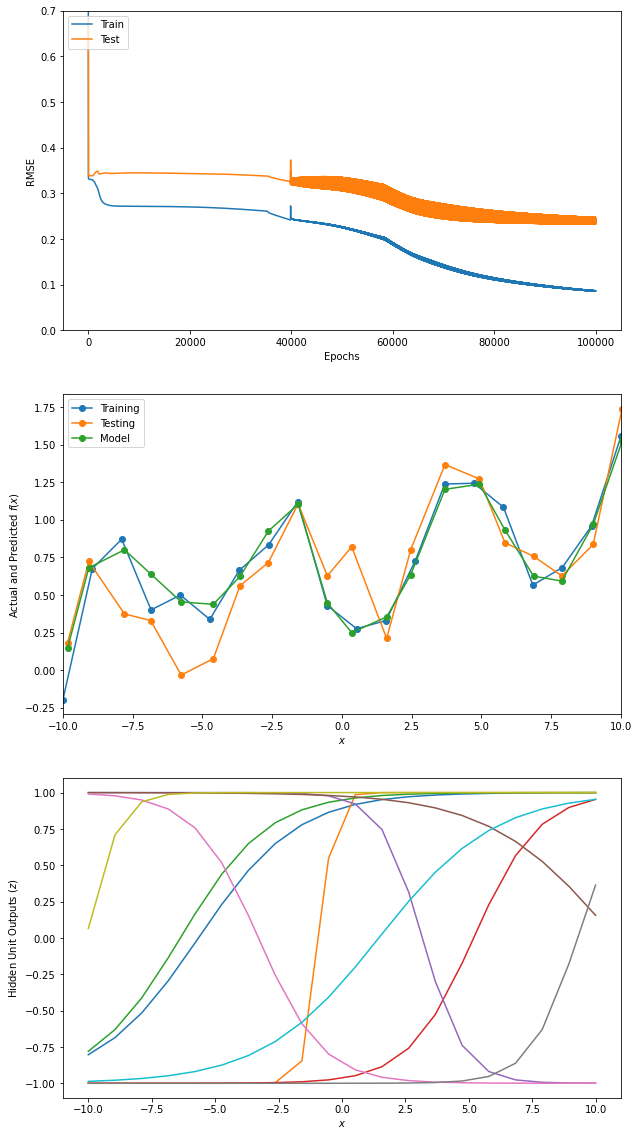

In [56]:
w = pack(V, W)
V, W = unpack(w, V.shape, W.shape)

# Take nEpochs steepest descent steps in gradient descent search in mean-squared-error function
nEpochs = 100000

# collect training and testing errors for plotting
errorTrace = np.zeros((nEpochs, 2))

fig = plt.figure(figsize=(10, 20))
for epoch in range(nEpochs):

    # V, W = unpack(w, Vshape, Wshape)
    
    # Forward pass on training data
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W

    # Error in output
    error = T - Y

    # Backward pass
    
    gradE_V = - X1.T @ ( ( error @ W[1:, :].T) * (1 - Z**2))
    gradE_W = - Z1.T @ error
        
    gradE_w = pack(gradE_V, gradE_W)
    
    w -= rho * gradE_w
    
    # V, W = unpack(w, Vshape, Wshape)

    # error traces for plotting
    errorTrace[epoch, 0] = np.sqrt(np.mean((error**2)))
    
    Ytest = addOnes(np.tanh(Xtest1 @ V)) @ W  #!! Forward pass in one line
    errorTrace[epoch, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

    if epoch % 2000 == 0 or epoch == nEpochs - 1:
        plt.clf()
        plt.subplot(3, 1, 1)
        plt.plot(errorTrace[:epoch, :])
        plt.ylim(0, 0.7)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend(('Train','Test'), loc='upper left')
        
        plt.subplot(3, 1, 2)
        plt.plot(X, T, 'o-', Xtest, Ttest, 'o-', Xtest, Ytest, 'o-')
        plt.xlim(-10, 10)
        plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
        plt.xlabel('$x$')
        plt.ylabel('Actual and Predicted $f(x)$')
        
        plt.subplot(3, 1, 3)
        plt.plot(X, Z)
        plt.ylim(-1.1, 1.1)
        plt.xlabel('$x$')
        plt.ylabel('Hidden Unit Outputs ($z$)');
        
        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)

print('Final RMSE', np.sqrt(np.mean((T - Y)**2)))

Now we can repeat this training loop, but this time using Adam.

Final RMSE 0.054299271517382994


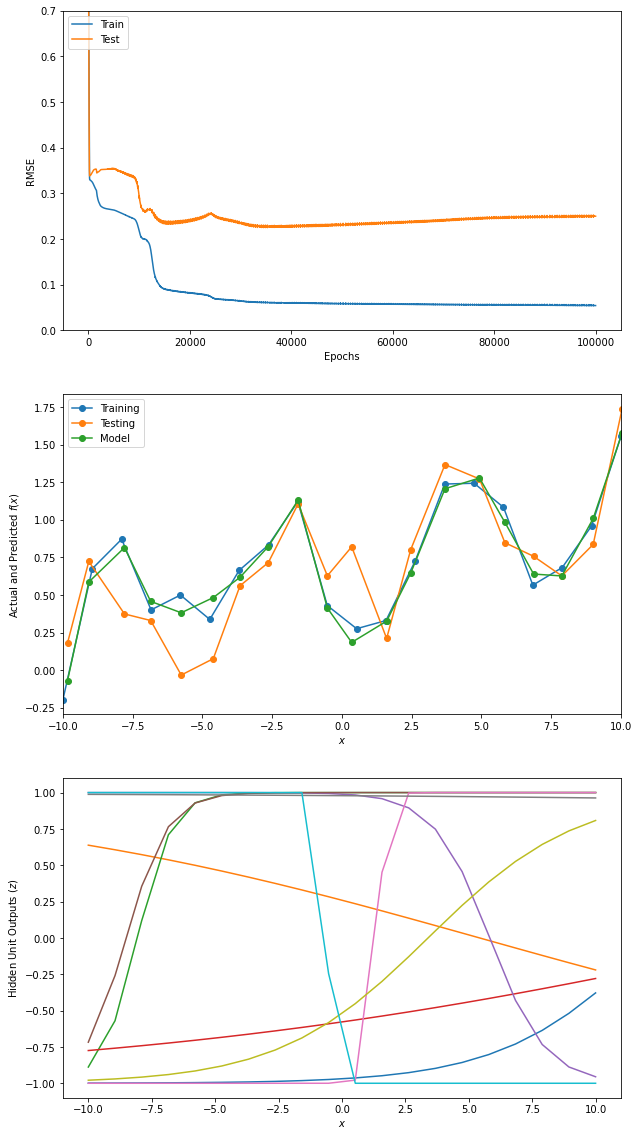

In [57]:
# Set parameters of neural network
nHiddens = 10

epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

rho = 0.001

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
Vshape = (1 + 1, nHiddens)
Wshape = (1 + nHiddens, nOutputs)
V = np.random.uniform(-0.1, 0.1, Vshape)
W = np.random.uniform(-0.1, 0.1, Wshape)
w = pack(V, W)
V, W = unpack(w, Vshape, Wshape)

mt = np.zeros_like(w)
vt = np.zeros_like(w)
beta1t = 1
beta2t = 1

# Take nReps steepest descent steps in gradient descent search in mean-squared-error function
nEpochs = 100000

# collect training and testing errors for plotting
errorTrace = np.zeros((nEpochs, 2))

fig = plt.figure(figsize=(10, 20))

for epoch in range(nEpochs):

    # Forward pass on training data
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W

    # Error in output
    error = T - Y

    # Backward pass
    
    gradE_V = - X1.T @ ( ( error @ W[1:, :].T) * (1 - Z**2))
    gradE_W = - Z1.T @ error
        
    gradE_w = pack(gradE_V, gradE_W)
     
    # approximate first and second moment
    mt = beta1 * mt + (1 - beta1) * gradE_w
    vt = beta2 * vt + (1 - beta2) * np.square(gradE_w)
    
    # bias corrected moment estimates
    beta1t *= beta1
    beta2t *= beta2
    mhat = mt / (1 - beta1t )
    vhat = vt / (1 - beta2t )               
    
    w -= rho * mhat / (np.sqrt(vhat) + epsilon)

    errorTrace[epoch, 0] = np.sqrt(np.mean((error**2)))
    
    Ytest = addOnes(np.tanh(Xtest1 @ V)) @ W  #!! Forward pass in one line
    errorTrace[epoch, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

    if epoch % 2000 == 0 or epoch == nEpochs - 1:
        plt.clf()
        plt.subplot(3, 1, 1)
        plt.plot(errorTrace[:epoch, :])
        plt.ylim(0, 0.7)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend(('Train','Test'), loc='upper left')
        
        plt.subplot(3, 1, 2)
        plt.plot(X, T, 'o-', Xtest, Ttest, 'o-', Xtest, Ytest, 'o-')
        plt.xlim(-10, 10)
        plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
        plt.xlabel('$x$')
        plt.ylabel('Actual and Predicted $f(x)$')
        
        plt.subplot(3, 1, 3)
        plt.plot(X, Z)
        plt.ylim(-1.1, 1.1)
        plt.xlabel('$x$')
        plt.ylabel('Hidden Unit Outputs ($z$)');
        
        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)

print('Final RMSE', np.sqrt(np.mean((T - Y)**2)))